In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [4]:
# Load the dataset
data_path = '/content/drive/MyDrive/air_quality_data_with_replaced_cities.csv'  # Update the path if needed
df = pd.read_csv(data_path)

# Clean city names in the dataframe
df['City'] = df['City'].str.strip().str.lower()

# Add some noise to the target variable to introduce variability
np.random.seed(42)
noise = np.random.normal(0, 0.5, df['AQI'].shape)
df['AQI'] += noise

# Ensure AQI is still within a realistic range
df['AQI'] = df['AQI'].clip(lower=0)

# Display the first few rows of the dataframe
print("Data Head:\n", df.head())

Data Head:
    Temperature  Relative_Humidity  Absolute_Humidity  Wind_Speed        CO  \
0    27.483571          53.577874           6.811145    6.513977  0.593828   
1    24.308678          55.607845           8.801250    3.155669  0.448396   
2    28.238443          60.830512          10.010487    6.739212  0.509612   
3    32.615149          60.538021          10.093961    7.711276  0.453772   
4    23.829233          36.223306           9.099869    5.826870  0.456550   

        NOx       NO2        O3        AQI       City  
0  0.269968  0.153757  0.079062  29.197214     lahore  
1  0.246232  0.137118  0.110733  26.380055  islamabad  
2  0.202982  0.153669  0.123714  29.772244    karachi  
3  0.167653  0.166299  0.114379  30.759051   peshawar  
4  0.234911  0.151466  0.119921  22.692313    sialkot  


In [5]:
# Define a function to print AQI for a specific city
def print_aqi_for_city(city_name, good_aqi_threshold=50):
    # Convert city name to lowercase and strip leading/trailing spaces
    city_name = city_name.strip().lower()

    # Debugging information
    print(f"Looking for city: {city_name}")

    city_data = df[df['City'] == city_name]
    if not city_data.empty:
        aqi = city_data['AQI'].values[0]
        if aqi <= good_aqi_threshold:
            print(f"The AQI for {city_name} is {aqi}. The air quality is good.")
        else:
            print(f"The AQI for {city_name} is {aqi}. The air quality is not good.")
    else:
        print(f"No data available for {city_name}.")


In [6]:
# Prepare data for modeling
X = df.drop(columns=['AQI', 'City'])
y = df['AQI']

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values (if any were introduced by the conversion)
X = X.dropna()

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Hyperparameter tuning for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [17]:
# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_

In [10]:
# Predict and evaluate
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Model Evaluation:\nMean Squared Error: {mse}\nR-squared: {r2}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Model Evaluation:
Mean Squared Error: 1.4108767008933438
R-squared: 0.8282608892981671


In [11]:
# Define thresholds for good and poor AQI
good_aqi_threshold = 50
poor_aqi_threshold = 100

good_aqi_cities = df[df['AQI'] <= good_aqi_threshold]['City']
poor_aqi_cities = df[df['AQI'] >= poor_aqi_threshold]['City']

print(f"Cities with good AQI (<= {good_aqi_threshold}):\n", good_aqi_cities)
print(f"Cities with poor AQI (>= {poor_aqi_threshold}):\n", poor_aqi_cities)

Cities with good AQI (<= 50):
 0         lahore
1      islamabad
2        karachi
3       peshawar
4        sialkot
         ...    
195       lahore
196    islamabad
197      karachi
198     peshawar
199      sialkot
Name: City, Length: 200, dtype: object
Cities with poor AQI (>= 100):
 Series([], Name: City, dtype: object)


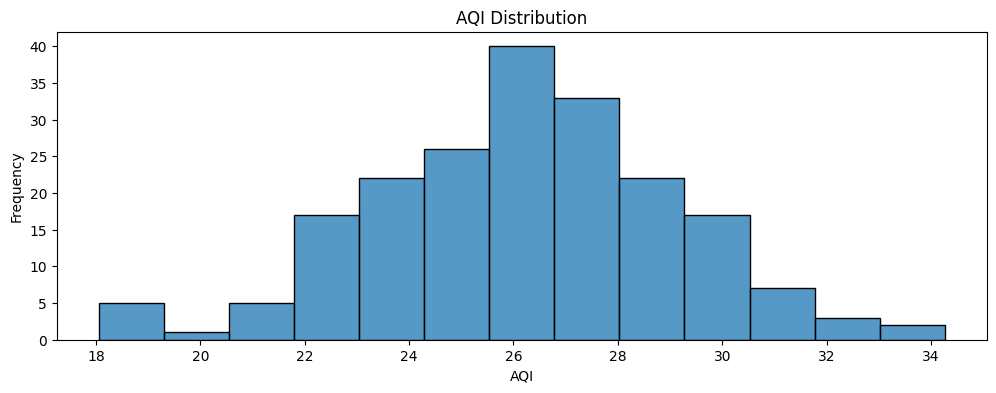

In [20]:
# Visualization
plt.figure(figsize=(12, 4))

# AQI Distribution
sns.histplot(df['AQI'])
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

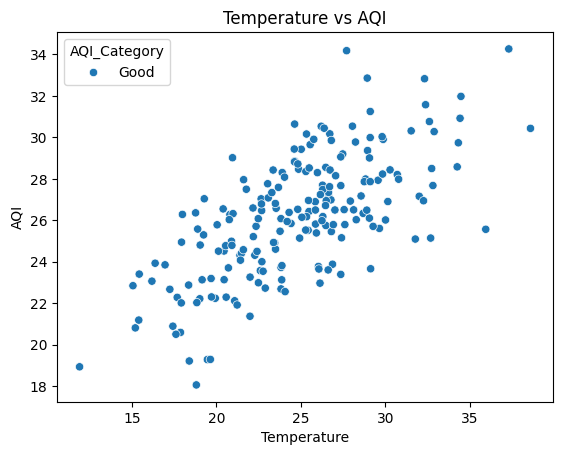

In [13]:
# Scatter plot of Temperature vs AQI colored by good/poor AQI
# adds new col to df which categ aqi as good or poor
df['AQI_Category'] = df['AQI'].apply(lambda x: 'Good' if x <= good_aqi_threshold else 'Poor')
sns.scatterplot(data=df, x='Temperature', y='AQI', hue='AQI_Category')
plt.title('Temperature vs AQI')
plt.xlabel('Temperature')
plt.ylabel('AQI')
plt.show()

In [14]:
# Example usage
print_aqi_for_city('lahore')

# Print the model evaluation metrics
print(f"Model Evaluation:\nMean Squared Error: {mse}\nR-squared: {r2}")


Looking for city: lahore
The AQI for lahore is 29.197214262520575. The air quality is good.
Model Evaluation:
Mean Squared Error: 1.4108767008933438
R-squared: 0.8282608892981671
